In [ ]:
# based on https://github.com/Christensen-Lab-Dartmouth/VAE_methylation

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.callbacks import Callback
import keras

import pydot
import graphviz
from keras.utils import plot_model
from tqdm.keras import TqdmCallback
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z

methyl_file_luad = os.path.join('./filtered_methylation_data', 'luad_top100kMAD_cpg.parquet')
methyl_file_read = os.path.join('./filtered_methylation_data', 'read_top100kMAD_cpg.parquet')
methyl_file_coad = os.path.join('./filtered_methylation_data', 'coad_top100kMAD_cpg.parquet')

methyl_df_luad = pd.read_parquet(methyl_file_luad)
methyl_df_read = pd.read_parquet(methyl_file_read)
methyl_df_coad = pd.read_parquet(methyl_file_coad)

methyl_df = pd.concat([methyl_df_luad, methyl_df_read], axis=0, ignore_index=True)

# Split 10% test set randomly
test_set_percent = 0.1
methyl_test_df = methyl_df.sample(frac=test_set_percent)
methyl_train_df = methyl_df.drop(methyl_test_df.index)

Num GPUs Available:  1


In [46]:
# Set hyper parameters
original_dim = methyl_df.shape[1]
latent_dim = 100

batch_size = 50
epochs = 50
learning_rate = 0.0005

epsilon_std = 1.0
beta = K.variable(0)
kappa = 1

# Input place holder for methylation data with specific input size
methyl_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(methyl_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(methyl_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

# The decoding layer is much simpler with a single layer and sigmoid activation
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
methyl_reconstruct = decoder_to_reconstruct(z)

class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded, z_mean, z_log_var):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
            x_input, x_decoded, z_mean, z_log_var = inputs
            loss = self.vae_loss(x_input, x_decoded, z_mean, z_log_var)
            self.add_loss(loss)
            return x_input 

class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 100000)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 100)       │ 10,000,100 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 100)       │ 10,000,100 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 100)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 100)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 100)       │          0 │ activation_6[0][… │
│                     │                   │            │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 100000)    │ 10,100,000 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_variational… │ (None, 100000)    │          0 │ input_layer_10[0… │
│ (CustomVariational… │                   │            │ dense_11[0][0],   │
│                     │                   │            │ activation_6[0][… │
│                     │                   │            │ activation_7[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,101,000 (114.83 MB)

 Trainable params: 30,100,600 (114.82 MB)

 Non-trainable params: 400 (1.56 KB)

100%|██████████| 50/50 [00:16<00:00,  3.04epoch/s, loss=6.05e+4, val_loss=6.12e+4]


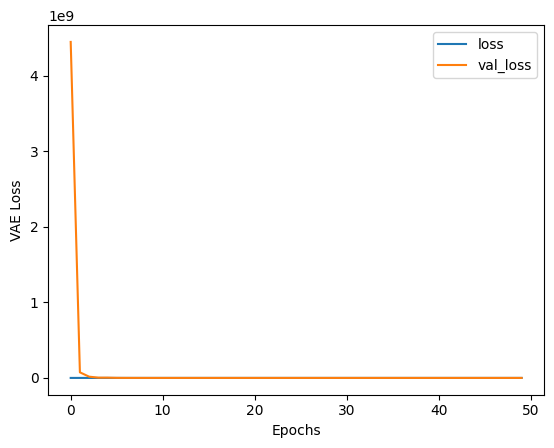

In [47]:
adam = optimizers.Adam(learning_rate=learning_rate)
vae_layer = CustomVariationalLayer()([methyl_input, methyl_reconstruct, z_mean_encoded, z_log_var_encoded])
vae = Model(methyl_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

vae.summary()

hist = vae.fit(np.array(methyl_train_df),
               shuffle=True,
               epochs=epochs,
               verbose=0,
               batch_size=batch_size,
               validation_data=(np.array(methyl_test_df), None),
               callbacks=[WarmUpCallback(beta, kappa), TqdmCallback()])

# Visualize training performance
history_df = pd.DataFrame(hist.history)
hist_plot_file = os.path.join('output', 'onehidden_vae_training.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

In [48]:
import json

def create_methylation_embedding(base_dir, case_id, methylation_file_name, model):
    methylation_file_path = os.path.join(base_dir, case_id, "DNA Methylation", methylation_file_name)

    if not os.path.exists(methylation_file_path):
        raise FileNotFoundError(f"Methylation file '{methylation_file_path}' not found.")

    df = pd.read_csv(methylation_file_path, sep="\t", header=None, names=["probe", "beta_value"])

    top_cpgs_file = os.path.join('filtered_methylation_data', 'top_100k_most_variable_cpg_sites.parquet')
    top_cpgs_df = pd.read_parquet(top_cpgs_file)
    top_cpg_sites = set(top_cpgs_df['CpG_Site'])

    filtered_df = df[df["probe"].isin(top_cpg_sites)]
    beta_values = filtered_df["beta_value"].astype(float).values

    expected_probe_count = 100000
    if len(beta_values) != expected_probe_count:
        return None

    input_array = np.array(beta_values, dtype=np.float32)
    input_array = np.expand_dims(input_array, axis=0)

    methylation_embedding = model.predict(input_array).tolist()

    return methylation_embedding

def create_methylation_embeddings(base_dir, model, model_name):
    case_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    for case_id in case_dirs:
        case_dir = os.path.join(base_dir, case_id)
        methylation_dir = os.path.join(case_dir, "DNA Methylation")
        metadata_path = os.path.join(case_dir, "aggregated_data", f'{case_id}_data.json')

        if not os.path.exists(metadata_path):
            print(f"No metadata found for case {case_id}, skipping...")
            continue
        
        with open(metadata_path, 'r') as f:
            case_metadata = json.load(f)
        
        methylation_JSON_base = case_metadata.get('methylation', {})
        if methylation_JSON_base.get('has_data') is False:
            print(f"Skipping case {case_id} due to missing data")
            continue 

        if 'embeddings' not in methylation_JSON_base:
            methylation_JSON_base['embeddings'] = []

        # Collect methylation file names from JSON metadata file
        for methylation_file_name in methylation_JSON_base['dna_methylation_filename']:
            embedding = create_methylation_embedding(base_dir, case_id, methylation_file_name, model)
            
            for file_entry in methylation_JSON_base['embeddings']:
                if file_entry['filename'] == methylation_file_name:
                    file_entry['embeddings'] = [e for e in file_entry['embeddings'] if e['model_name'] != model_name]
            
            embedding_entry = {
                "model_name": model_name,
                "embedding": embedding
            }

            file_entry = next((entry for entry in methylation_JSON_base['embeddings'] if entry['filename'] == methylation_file_name), None)
            if not file_entry:
                file_entry = {
                    "filename": methylation_file_name,
                    "embeddings": []
                }
                methylation_JSON_base['embeddings'].append(file_entry)
            
            file_entry['embeddings'].append(embedding_entry)
        
        with open(metadata_path, 'w') as f:
            json.dump(case_metadata, f, indent=4)

        print(f"Methylation embeddings added for case {case_id} in the metadata.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Methylation embeddings added for case b3c267aa-345d-40d8-a8da-f9f08c64f9c7 in the metadata.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Methylation embeddings added for case a85e8208-a6f5-4e91-8f35-ef574f4273fc in the metadata.
Methylation embeddings added for case 835c3e23-ac2b-4bc9-ac65-e3e81adecf77 in the metadata.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Methylation embeddings added for case ea923671-3903-4a79-830d-e7e4b1eabab0 in the metadata.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Methylation embeddings added for case 131e0571-de86-415f-b3fb-dc9f971258d3 in the metadata.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Methylation embeddings added for case 1c111912-c664-42f5-9802-065b1994a2f4 in the metadata.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Methylation embeddings added for case acd51808-870c-4684-a2de-aa0b058729e1 in the metadata.
Methylation embeddings added for case a9cb21d1-4c4a-4f30-ad4d-c54bed26f187 in the metadata.
Methylation embeddings added for ca

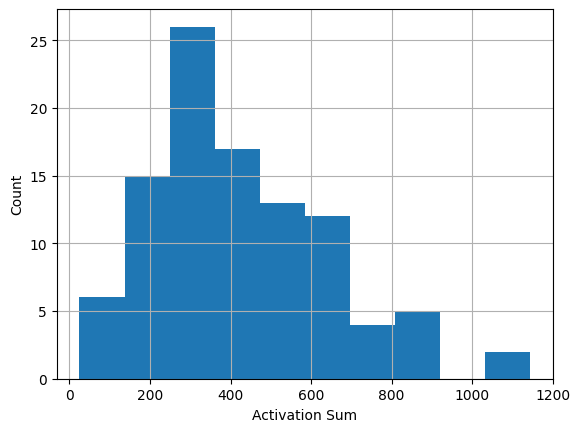

In [52]:
# Model to compress input
encoder = Model(methyl_input, z_mean_encoded)
encoded_methyl_df = encoder.predict_on_batch(methyl_df)
encoded_methyl_df_COAD = encoder.predict_on_batch(methyl_df_coad)

encoded_methyl_df = pd.DataFrame(encoded_methyl_df, index=methyl_df.index)
encoded_methyl_df_COAD = pd.DataFrame(encoded_methyl_df_COAD, index=methyl_df_coad.index)

create_methylation_embeddings("cases", encoder, "VAE_100k")

encoded_methyl_df.columns.name = 'sample_id'
encoded_methyl_df.columns = encoded_methyl_df.columns + 1

decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

# What are the most and least activated nodes
sum_node_activity = encoded_methyl_df.sum(axis=0).sort_values(ascending=False)

# Top 10 most active nodes
print(sum_node_activity.head(10))

# Bottom 10 least active nodes
print(sum_node_activity.tail(10))

sum_node_activity.hist()
plt.xlabel('Activation Sum')
plt.ylabel('Count')
output_path = os.path.join("output", "sum_node_activity_hist.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight')

In [50]:
input_methyl_reconstruct = decoder.predict(np.array(encoded_methyl_df_COAD))
input_methyl_reconstruct = pd.DataFrame(input_methyl_reconstruct, index=methyl_df_coad.index,
                                        columns=methyl_df_coad.columns)
print(input_methyl_reconstruct.head(2))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
   cg16328106  cg25363807  cg18158151  cg11738485  cg25737323  cg23428985  \
0    0.810727    0.110980    0.729607    0.564139    0.690427    0.658829   
1    0.746555    0.166692    0.678437    0.564978    0.668067    0.643832   

   cg20295442  cg05037927  cg20912169  cg13257636  ...  cg17206420  \
0    0.638647    0.710516    0.625921    0.681266  ...    0.374391   
1    0.706963    0.640672    0.698724    0.659672  ...    0.308468   

   cg10537807  cg08335199  cg24642169  cg15700022  cg16101574  cg12598340  \
0    0.172039    0.779304    0.246402    0.717087    0.873902    0.125320   
1    0.155195    0.681535    0.262169    0.667284    0.851161    0.118045   

   cg06235642  cg19263630  cg11507770  
0    0.550858    0.746140    0.696436  
1    0.495718    0.705742    0.716195  

[2 rows x 100000 columns]


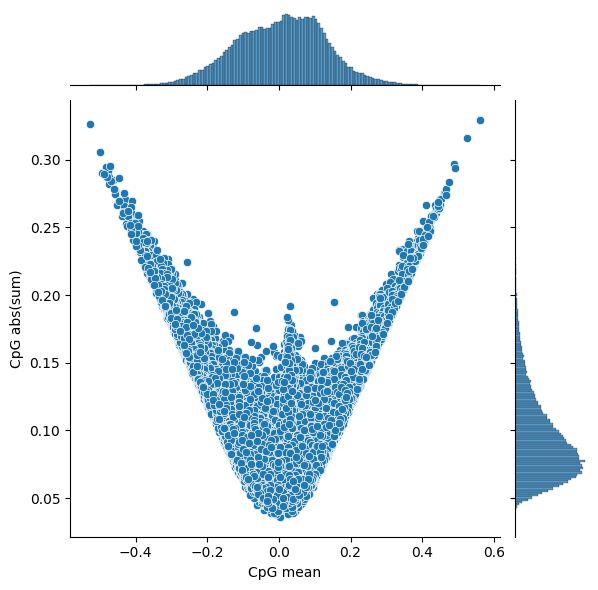

In [ ]:
reconstruction_fidelity = methyl_df - input_methyl_reconstruct

cpg_mean = reconstruction_fidelity.mean(axis=0)
cpg_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(methyl_df.shape[0])
cpg_summary = pd.DataFrame([cpg_mean, cpg_abssum], index=['CpG mean', 'CpG abs(sum)']).T
cpg_summary.sort_values(by='CpG abs(sum)', ascending=False).head()

g = sns.jointplot(x='CpG mean', y='CpG abs(sum)', data=cpg_summary, kind="scatter")